In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow as tf
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import re
import pickle
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Read the data from input

df = pd.read_csv('train.csv')
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# Any results you write to the current directory are saved as output.
df.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


### Check Data Types

In [9]:
print(df.dtypes)

Year_Factor                    int64
State_Factor                  object
building_class                object
facility_type                 object
floor_area                   float64
                              ...   
direction_peak_wind_speed    float64
max_wind_speed               float64
days_with_fog                float64
site_eui                     float64
id                             int64
Length: 64, dtype: object


In [10]:
df.drop(["id"], axis=1, inplace=True)

In [11]:
df.shape

(75757, 63)

### Drop Duplicate rows

In [12]:
df.drop_duplicates(inplace=True)
df.shape

(75718, 63)

### Filling the missing data with the median value and droping feature columns with lots of missing data

### Visualize all the missing data, the white lines are missing values

In [13]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df[missing_value_df.percent_missing != 0.0]

,column_name,percent_missing
year_built,year_built,2.399694
energy_star_rating,energy_star_rating,35.238649
direction_max_wind_speed,direction_max_wind_speed,54.240735
direction_peak_wind_speed,direction_peak_wind_speed,55.202198
max_wind_speed,max_wind_speed,54.240735
days_with_fog,days_with_fog,60.465147


In [14]:
col_high_missing = ['direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
df = df.drop(col_high_missing,1)
df

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.500000,...,56.972603,0,0,0,0,14,0,0,0,248.682615
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.500000,...,56.972603,0,0,0,0,14,0,0,0,26.500150
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.500000,...,56.972603,0,0,0,0,14,0,0,0,24.693619
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.500000,...,56.972603,0,0,0,0,14,0,0,0,48.406926
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.500000,...,56.972603,0,0,0,0,14,0,0,0,3.899395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75752,6,State_11,Commercial,Office_Uncategorized,20410.0,1995.0,8.0,36.6,28,43.451613,...,55.147541,6,0,0,0,25,3,0,0,132.918411
75753,6,State_11,Residential,5plus_Unit_Building,40489.0,1910.0,98.0,36.6,28,43.451613,...,55.147541,6,0,0,0,25,3,0,0,39.483672
75754,6,State_11,Commercial,Commercial_Other,28072.0,1917.0,NaN,36.6,26,36.612903,...,47.911202,26,2,0,0,6,0,0,0,48.404398
75755,6,State_11,Commercial,Commercial_Other,53575.0,2012.0,NaN,36.6,26,36.612903,...,47.911202,26,2,0,0,6,0,0,0,592.022750


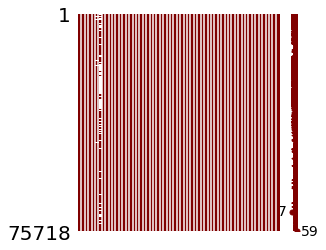

In [15]:
# search for missing data
import missingno as msno
msno.matrix(df, figsize=(4,4), color=(0.5,0,0))

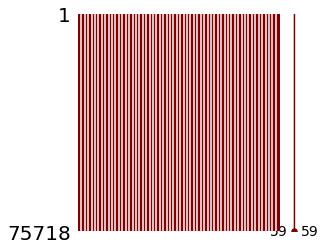

In [16]:
df = df.fillna(df.median())

# Visualize again
import missingno as msno
msno.matrix(df, figsize=(4,4), color=(0.5,0,0))

### Correlation Analysis

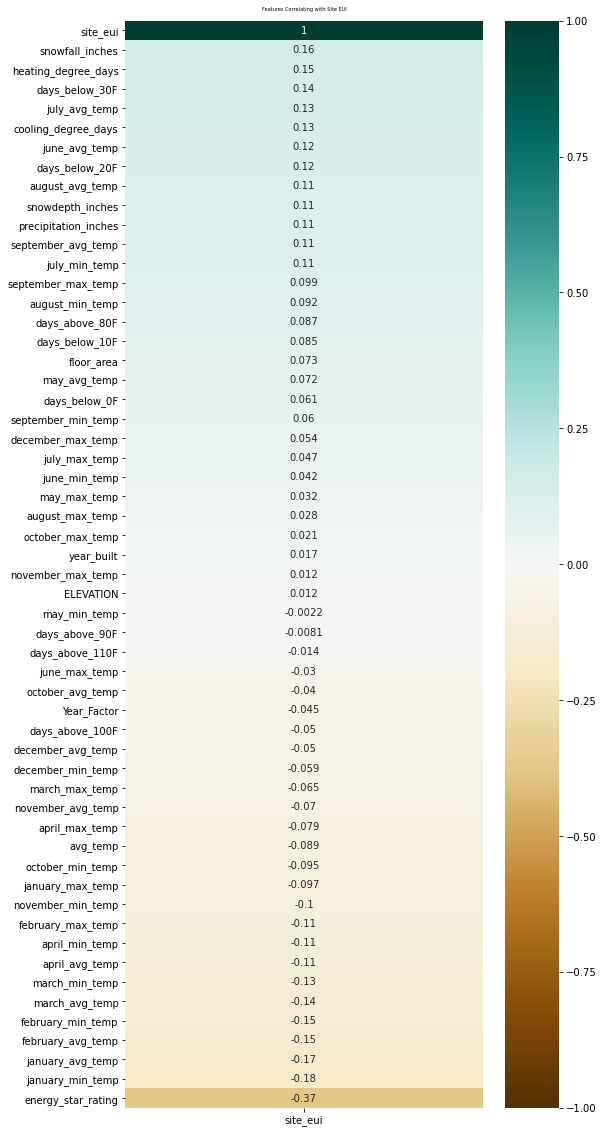

In [17]:
plt.figure(figsize=(8, 20))
heatmap = sns.heatmap(df.corr()[['site_eui']].sort_values(by='site_eui', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Site EUI', fontdict={'fontsize':5}, pad=10);

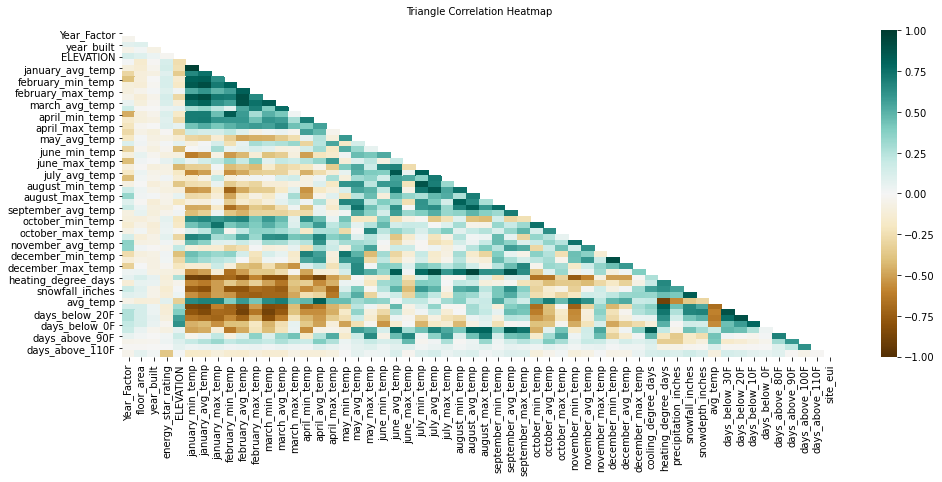

In [18]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=False, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':10}, pad=16);

In [19]:
def correlation(dataframe, threshold):
    high_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataframe.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and ((corr_matrix.columns[j], corr_matrix.columns[i]) not in high_corr):
                columns = (corr_matrix.columns[i], corr_matrix.columns[j]) # getting the name of the columns
                high_corr.add(columns)

    return high_corr

high_corr = correlation(df, 0.95)
print(high_corr)

{('january_avg_temp', 'january_min_temp'), ('cooling_degree_days', 'august_avg_temp')}


In [20]:
df.drop(columns=['january_min_temp'], 
        axis=1, inplace=True)

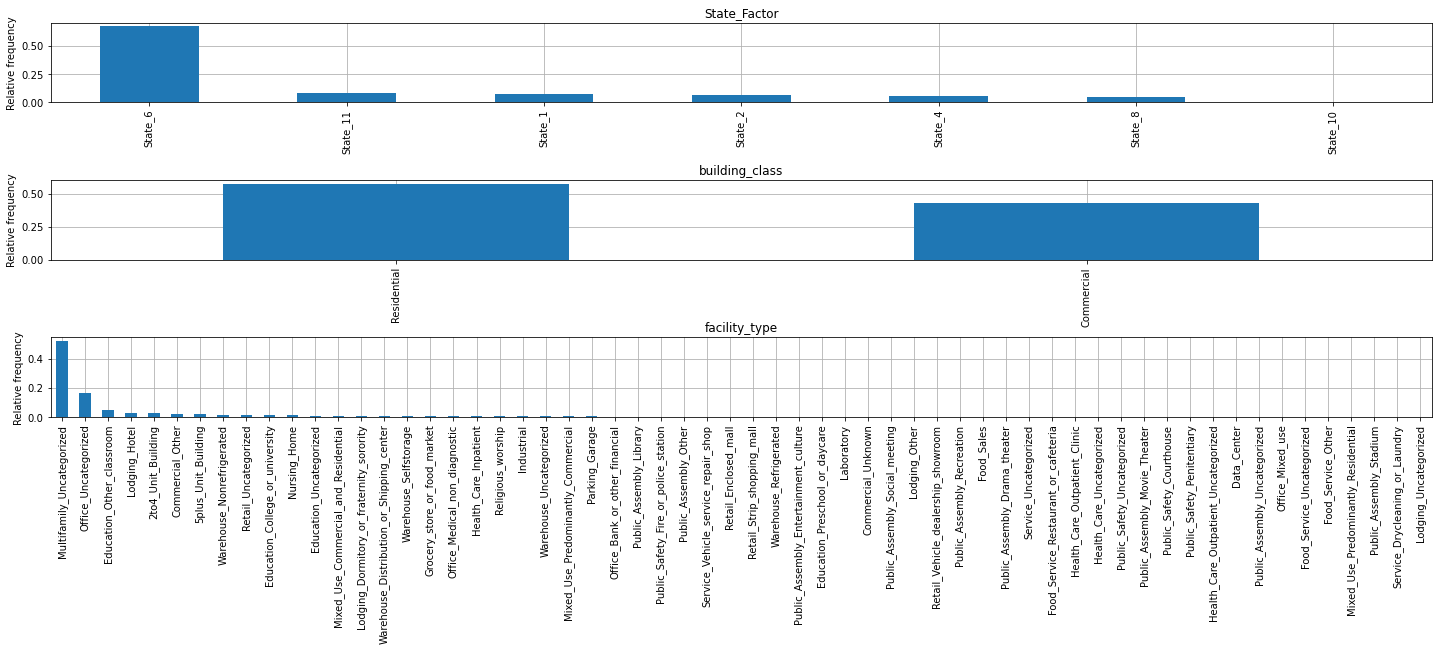

In [21]:
def plot_distbn(column, column_name, num):
    plt.subplot(num)
    column.value_counts(normalize=True).plot(kind='bar')
    plt.title(column_name)
    plt.ylabel('Relative frequency')
    plt.tight_layout()
    plt.grid(True)
    
    return column.value_counts(normalize=True)


plt.rcParams['axes.axisbelow'] = True
plt.figure(figsize=(20,6))
rel_freqs1 = plot_distbn(df['State_Factor'], 'State_Factor', 311)
rel_freqs2 = plot_distbn(df['building_class'], 'building_class', 312)
rel_freqs3 = plot_distbn(df['facility_type'], 'facility_type', 313)

In [22]:
df = df.drop('State_Factor',1)

In [23]:
significant = rel_freqs3.index[:6].tolist()
print(significant)

['Multifamily_Uncategorized', 'Office_Uncategorized', 'Education_Other_classroom', 'Lodging_Hotel', '2to4_Unit_Building', 'Commercial_Other']


In [24]:
df['facility_type'].loc[~df['facility_type'].isin(significant)] = 'Others'
df['facility_type'].loc[~df['facility_type'].isin(significant)] = 'Others'
df.head()

,Year_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_avg_temp,january_max_temp,february_min_temp,...,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui
0,1,Commercial,Others,61242.0,1942.0,11.0,2.4,50.5,68,35,...,56.972603,0,0,0,0,14,0,0,0,248.682615
1,1,Commercial,Others,274000.0,1955.0,45.0,1.8,50.5,68,35,...,56.972603,0,0,0,0,14,0,0,0,26.500150
2,1,Commercial,Others,280025.0,1951.0,97.0,1.8,50.5,68,35,...,56.972603,0,0,0,0,14,0,0,0,24.693619
3,1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,50.5,68,35,...,56.972603,0,0,0,0,14,0,0,0,48.406926
4,1,Commercial,Others,66000.0,1985.0,100.0,2.4,50.5,68,35,...,56.972603,0,0,0,0,14,0,0,0,3.899395


In [25]:
for x in ['site_eui']:
    q75, q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25
    
    ul = q75+(1.5*intr_qr)
    ll = q25-(1.5*intr_qr)
    
    df.loc[df[x]<ll,x] = np.nan
    df.loc[df[x]>ul,x] = np.nan

df['site_eui'].isnull().sum()

3845

In [26]:
df = df.dropna(axis = 0)

In [27]:
for col in df.iloc[:,:-1]:
    if df[col].dtype != 'object':
        df[col] = (df[col]- df[col].min())/(df[col].max()-df[col].min())

In [28]:
enc = OrdinalEncoder()

for col in df:
    if df[col].dtype =='object':
        df[col] = enc.fit_transform(df[col].values.reshape(-1,1))

Training done using Random Forest


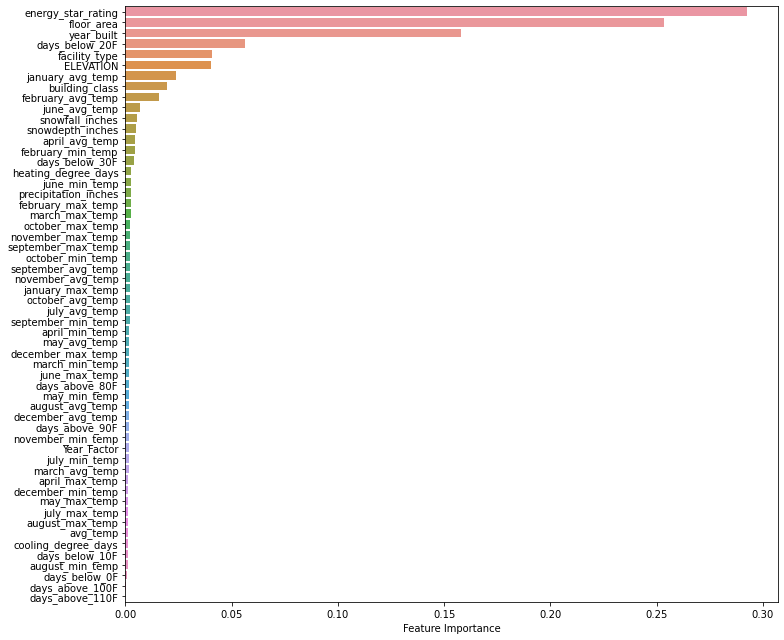

In [25]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=80, max_features='auto')
rf.fit(df.iloc[:,:-1], df['site_eui'])
print("Training done using Random Forest")

ranking = np.argsort(-rf.feature_importances_)
f, ax = plt.subplots(figsize=(11,9))
sns.barplot(x=rf.feature_importances_[ranking], y=df.iloc[:,:-1].columns.values[ranking], orient='h')
ax.set_xlabel("Feature Importance")
plt.tight_layout()
plt.show()

In [29]:
df['SpringTemp'] = (df.march_avg_temp + df.april_avg_temp + df.may_avg_temp)/3
df['SummerTemp'] = (df.june_avg_temp + df.july_avg_temp + df.august_avg_temp)/3
df['FallTemp'] = (df.september_avg_temp + df.october_avg_temp + df.november_avg_temp)/3
df['WinterTemp'] = (df.december_avg_temp + df.january_avg_temp + df.february_avg_temp)/3

df['floorxBuilt'] = df.floor_area * df.year_built 
df['floorxEnergy'] = df.floor_area * df.energy_star_rating
df['floorxBuiltxEnergy'] = df.floor_area * df.year_built * df.energy_star_rating
df['floorxHeatCool'] = df.floor_area *(df.cooling_degree_days + df.heating_degree_days)

df["freezing_days"] = df.days_below_0F + df.days_below_10F
df["cold_days"] = df.days_below_20F + df.days_below_30F
df["warm_days"] = df.days_above_80F + df.days_above_90F
df["hot_days"] = df.days_above_100F + df.days_above_110F
    
df["floor_areaxenergy_star_rating"] = df.floor_area*df.energy_star_rating
df["floor_areaxELEVATION"] = df.floor_area*df.ELEVATION

df["snow_rain_inches"] = df.snowfall_inches + df.precipitation_inches

In [30]:
df = df.drop(['days_below_30F', 'days_below_20F', 'days_below_10F',
       'days_below_0F', 'days_above_80F', 'days_above_90F', 'days_above_100F',
       'days_above_110F','precipitation_inches', 'snowfall_inches', 'snowdepth_inches', 'january_avg_temp', 
         'january_max_temp', 'february_min_temp',
       'february_avg_temp', 'february_max_temp', 'march_min_temp',
       'march_avg_temp', 'march_max_temp', 'april_min_temp', 'april_avg_temp',
       'april_max_temp', 'may_min_temp', 'may_avg_temp', 'may_max_temp',
       'june_min_temp', 'june_avg_temp', 'june_max_temp', 'july_min_temp',
       'july_avg_temp', 'july_max_temp', 'august_min_temp', 'august_avg_temp',
       'august_max_temp', 'september_min_temp', 'september_avg_temp',
       'september_max_temp', 'october_min_temp', 'october_avg_temp',
       'october_max_temp', 'november_min_temp', 'november_avg_temp',
       'november_max_temp', 'december_min_temp', 'december_avg_temp',
       'december_max_temp', 'cooling_degree_days', 'heating_degree_days'],1)

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, df['site_eui'], test_size=0.2, random_state=42)

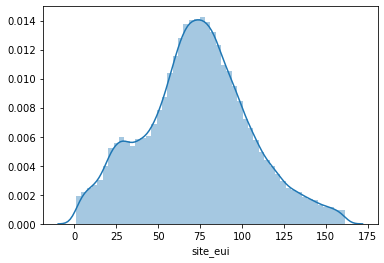

In [32]:
ax = sns.distplot(y_train)
plt.show()

In [33]:
X_train.columns

Index(['Year_Factor', 'building_class', 'facility_type', 'floor_area',
       'year_built', 'energy_star_rating', 'ELEVATION', 'avg_temp', 'site_eui',
       'SpringTemp', 'SummerTemp', 'FallTemp', 'WinterTemp', 'floorxBuilt',
       'floorxEnergy', 'floorxBuiltxEnergy', 'floorxHeatCool', 'freezing_days',
       'cold_days', 'warm_days', 'hot_days', 'floor_areaxenergy_star_rating',
       'floor_areaxELEVATION', 'snow_rain_inches'],
      dtype='object')

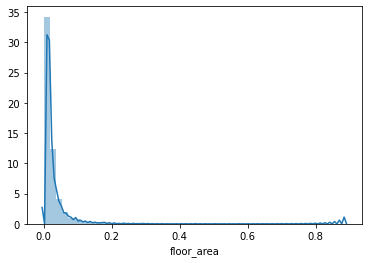

In [34]:
sns.distplot(X_train.floor_area)

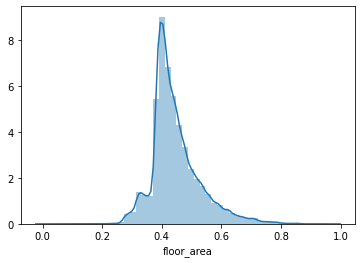

In [35]:
X_train.floor_area = (X_train.floor_area)**(1/5)
X_test.floor_area = (X_test.floor_area)**(1/5)
sns.distplot(X_train.floor_area)

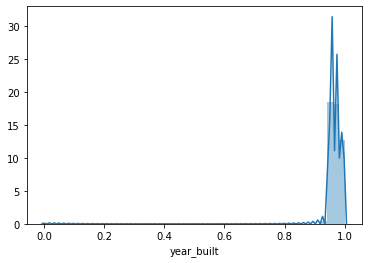

In [36]:
sns.distplot(X_train.year_built)

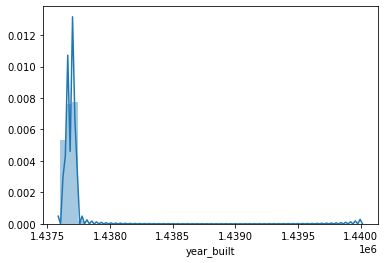

In [37]:
X_train.year_built = (1200-X_train.year_built)**(2)
X_test.year_built = (1200- X_test.year_built)**(2)
sns.distplot(X_train.year_built)

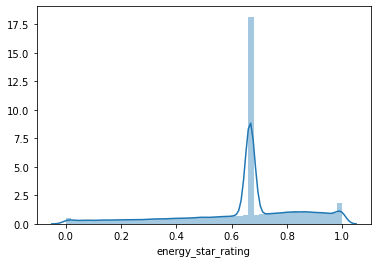

In [38]:
sns.distplot(X_train.energy_star_rating)

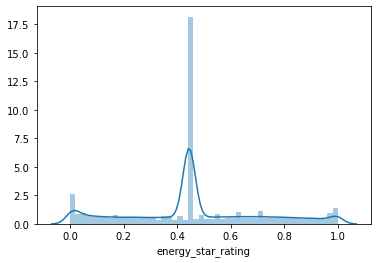

In [39]:
X_train.energy_star_rating = (X_train.energy_star_rating)**2
X_test.energy_star_rating = (X_test.energy_star_rating)**2
sns.distplot(X_train.energy_star_rating)

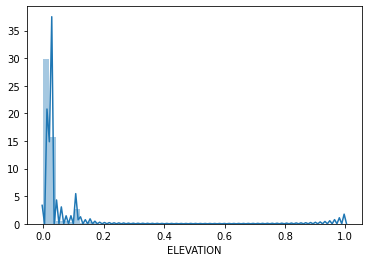

In [40]:
sns.distplot(X_train.ELEVATION)

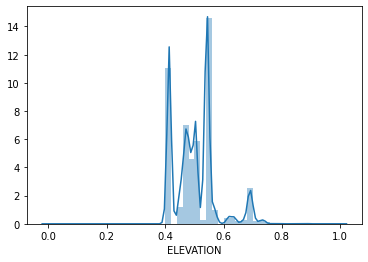

In [41]:
X_train.ELEVATION = (X_train.ELEVATION)**(1/6)
X_test.ELEVATION = (X_test.ELEVATION)**(1/6)
sns.distplot(X_train.ELEVATION)

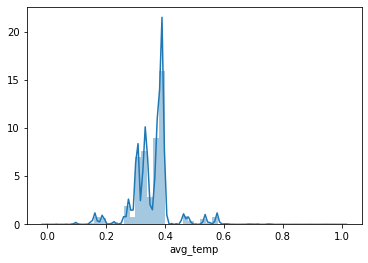

In [42]:
sns.distplot(X_train.avg_temp)

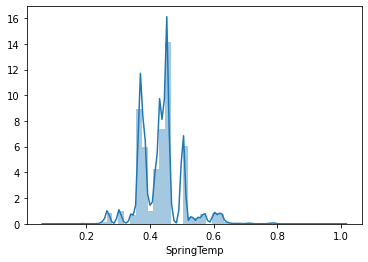

In [43]:
sns.distplot(X_train.SpringTemp)

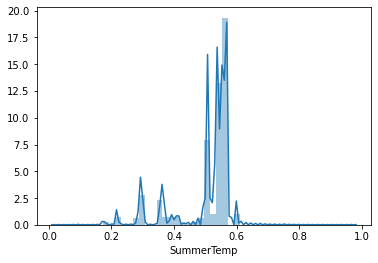

In [44]:
sns.distplot(X_train.SummerTemp)

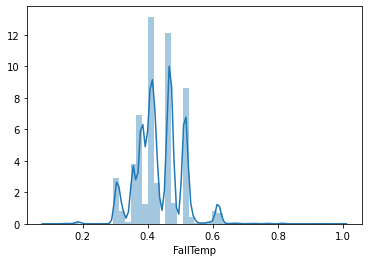

In [45]:
sns.distplot(X_train.FallTemp)

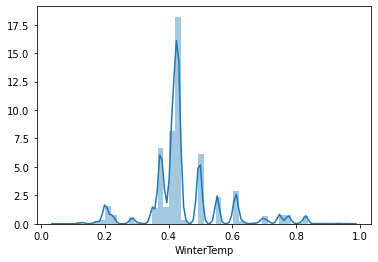

In [46]:
sns.distplot(X_train.WinterTemp)

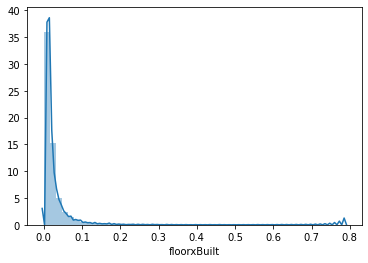

In [47]:
sns.distplot(X_train.floorxBuilt)

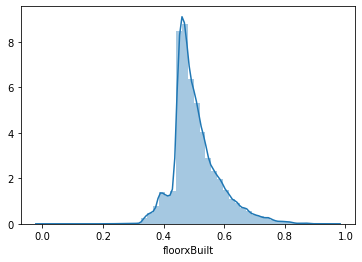

In [48]:
X_train.floorxBuilt = (X_train.floorxBuilt)**(1/6)
X_test.floorxBuilt = (X_test.floorxBuilt)**(1/6)
sns.distplot(X_train.floorxBuilt)

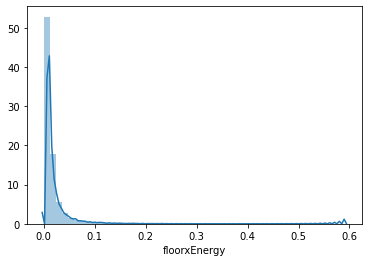

In [49]:
sns.distplot(X_train.floorxEnergy)

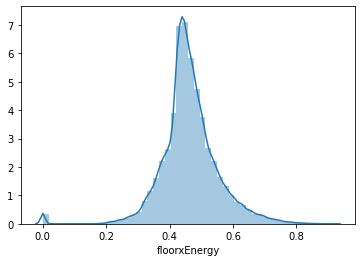

In [50]:
X_train.floorxEnergy = (X_train.floorxEnergy)**(1/6)
X_test.floorxEnergy = (X_test.floorxEnergy)**(1/6)
sns.distplot(X_train.floorxEnergy)

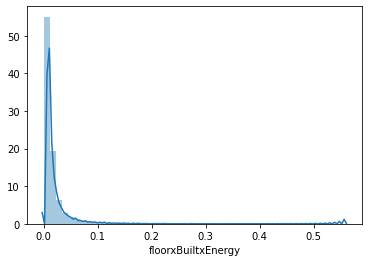

In [51]:
sns.distplot(X_train.floorxBuiltxEnergy)

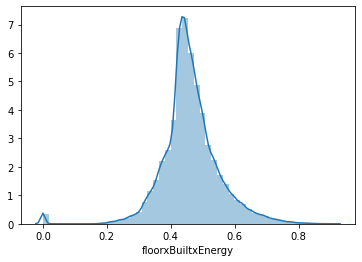

In [52]:
X_train.floorxBuiltxEnergy = (X_train.floorxBuiltxEnergy)**(1/6)
X_test.floorxBuiltxEnergy = (X_test.floorxBuiltxEnergy)**(1/6)
sns.distplot(X_train.floorxBuiltxEnergy)

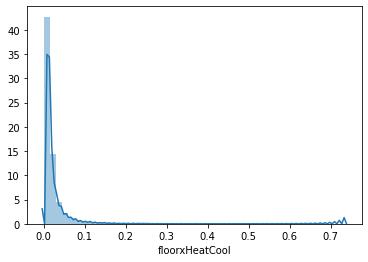

In [53]:
sns.distplot(X_train.floorxHeatCool)

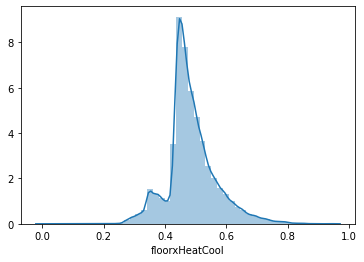

In [54]:
X_train.floorxHeatCool = X_train.floorxHeatCool**(1/6)
X_test.floorxHeatCool = X_test.floorxHeatCool**(1/6)
sns.distplot(X_train.floorxHeatCool)

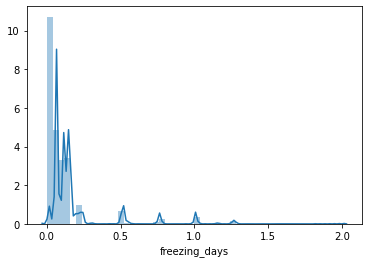

In [55]:
sns.distplot(X_train.freezing_days)

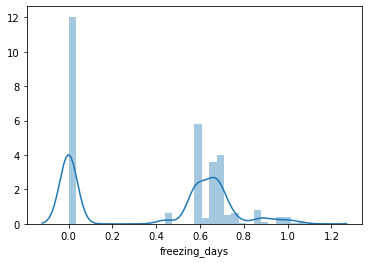

In [56]:
X_train.freezing_days = (X_train.freezing_days)**(1/5)
X_test.freezing_days = (X_test.freezing_days)**(1/5)
sns.distplot(X_train.freezing_days)

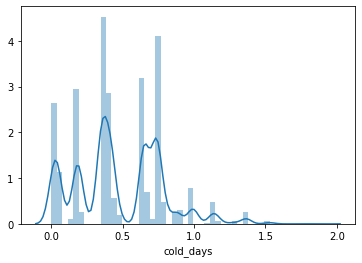

In [57]:
sns.distplot(X_train.cold_days)

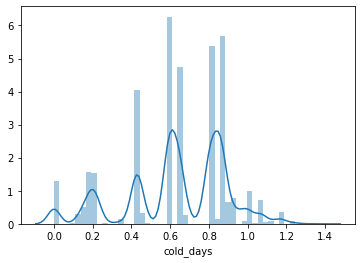

In [58]:
X_train.cold_days = X_train.cold_days**(1/2)
X_test.cold_days = X_test.cold_days**(1/2)
sns.distplot(X_train.cold_days)

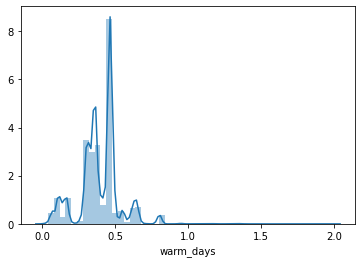

In [59]:
sns.distplot(X_train.warm_days)

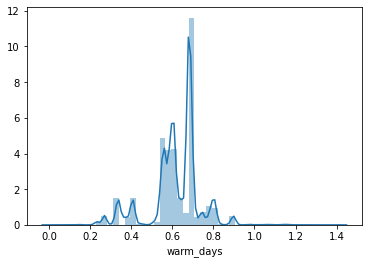

In [60]:
X_train.warm_days = X_train.warm_days**(1/2)
X_test.warm_days = X_test.warm_days**(1/2)
sns.distplot(X_train.warm_days)

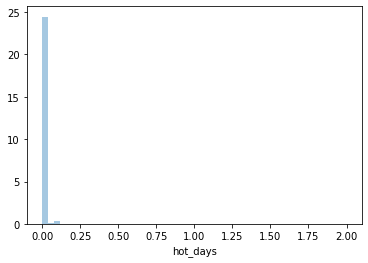

In [61]:
sns.distplot(X_train.hot_days)

In [62]:
X_train = X_train.drop('hot_days',1)
X_test = X_test.drop('hot_days',1)

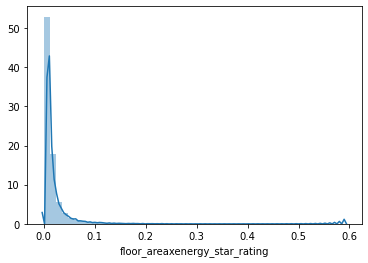

In [63]:
sns.distplot(X_train.floor_areaxenergy_star_rating)

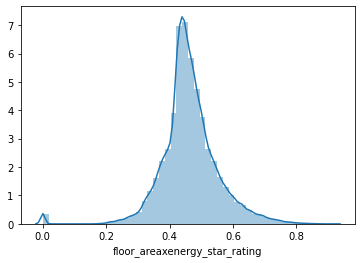

In [64]:
X_train.floor_areaxenergy_star_rating = X_train.floor_areaxenergy_star_rating**(1/6)
X_test.floor_areaxenergy_star_rating = X_test.floor_areaxenergy_star_rating**(1/6)
sns.distplot(X_train.floor_areaxenergy_star_rating)

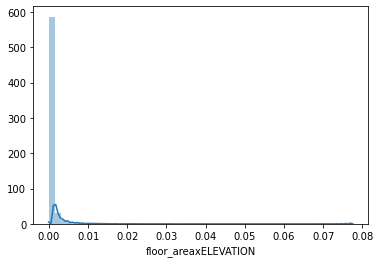

In [65]:
sns.distplot(X_train.floor_areaxELEVATION)

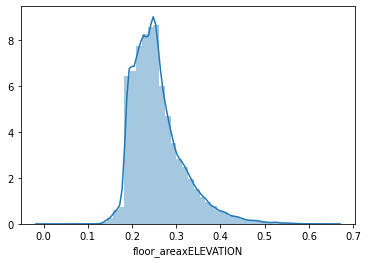

In [66]:
X_train.floor_areaxELEVATION = X_train.floor_areaxELEVATION**(1/6)
X_test.floor_areaxELEVATION = X_test.floor_areaxELEVATION**(1/6)
sns.distplot(X_train.floor_areaxELEVATION)

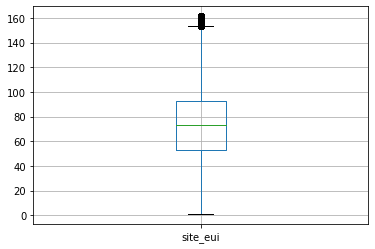

In [67]:
pd.DataFrame(y_train).boxplot()

## Ensembling

In [68]:
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('XGB', XGBRegressor()))
    level0.append(('SVR', SVR()))
    level0.append(('GBR', GradientBoostingRegressor()))
#    level0.append(('CATB', CatBoostRegressor())),
    level0.append(('LGBM', LGBMRegressor()))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=10)
    return model

## Tuning Parameters

In [65]:
reg1 = XGBRegressor(random_state=42)
reg2 = SVR()
reg3 = GradientBoostingRegressor(random_state=42)
#reg4 = CatBoostRegressor(random_state=42)
reg5 = LGBMRegressor(random_state=42)
#reg6 = get_stacking()

# Initiaze the hyperparameters for each dictionary
param1 = {}
param1['regressor__n_estimators'] = [50, 100, 250]
param1['regressor__max_depth'] = [3, 6, 10]
param1['regressor__learning_rate'] = [0.01, 0.05, 0.1]
param1['regressor__colsample_bytree']: [0.3, 0.7]
param1['regressor'] = [reg1]

param2 = {}
#param2['regressor__kernel'] = ["rbf", "sigmoid", "poly"]
param2['regressor__C'] = [1.5, 2, 2.5, 3, 3.5]
param2['regressor'] = [reg2]

param3 = {}
param3['regressor__max_depth'] = [3,4,5]
param3['regressor__n_estimators'] = [100, 200, 300]
param3['regressor__learning_rate'] = [0.01, 0.05, 0.1]
param3['regressor'] = [reg3]

# param4 = {}
# param4['regressor__n_estimators'] = [100,200,500]
# param4['regressor__learning_rate'] = [.001,0.01,.1]
# param4['regressor__max_depth'] = [1,2,4]
# param4['regressor'] = [reg4]

param5 = {}
param5['regressor__num_leaves'] = [200,300,500]
param5['regressor__learning_rate'] = [.001,0.01,.1]
param5['regressor__feature_fraction'] = [0.3,0.6,0.9]
param5['regressor__bagging_freq'] = [50,70,90]
param5['regressor'] = [reg5]

params = [param1, param2, param3, param5]

def tune(reg, param):
    pipeline = Pipeline([('regressor', reg)])
    rs = RandomizedSearchCV(pipeline, param, cv=5, scoring='neg_mean_squared_error')
    rs.fit(X_train, y_train)
    return rs.best_params_, rs.best_score_

In [66]:
tune(reg1, param1)

({'regressor__n_estimators': 250,
  'regressor__max_depth': 10,
  'regressor__learning_rate': 0.1,
  'regressor': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=0.1, max_delta_step=None, max_depth=10,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=250, n_jobs=None, num_parallel_tree=None,
               random_state=42, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=None, tree_method=None,
               validate_parameters=None, verbosity=None)},
 -0.0013563392015678972)

In [67]:
tune(reg2, param2)

({'regressor__C': 3, 'regressor': SVR(C=3)}, -1011.0606475712257)

In [68]:
tune(reg3, param3)

({'regressor__n_estimators': 200,
  'regressor__max_depth': 5,
  'regressor__learning_rate': 0.1,
  'regressor': GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42)},
 -0.004866594747211121)

In [69]:
tune(reg5, param5)

[LightGBM] [Warning] bagging_freq is set=50, subsample_freq=0 will be ignored. Current value: bagging_freq=50
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=50, subsample_freq=0 will be ignored. Current value: bagging_freq=50
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=50, subsample_freq=0 will be ignored. Current value: bagging_freq=50
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=50, subsample_freq=0 will be ignored. Current value: bagging_freq=50
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=50, subsample_freq=0 wi

({'regressor__num_leaves': 500,
  'regressor__learning_rate': 0.1,
  'regressor__feature_fraction': 0.9,
  'regressor__bagging_freq': 50,
  'regressor': LGBMRegressor(bagging_freq=50, feature_fraction=0.9, num_leaves=500,
                random_state=42)},
 -0.12391991547876809)

## Model Validation

In [63]:
def run_exps(X_train, y_train, X_test, y_test) -> pd.DataFrame:
    
    dfs = []
    models = [
          ('Stack', get_stacking()),
          ('XGB', XGBRegressor(n_estimators = 250, max_depth = 10, learning_rate = 0.1)), 
          ('SVR', SVR(C = 3)),
#          ('CATB', CatBoostRegressor(n_estimators = 500, max_depth = 4, learning_rate = 0.1)),
          ('LGBM', LGBMRegressor(num_leaves = 500, feature_fraction = 0.9, bagging_freq = 50)),
          ('GBR', GradientBoostingRegressor(n_estimators = 200, max_depth = 5)),
          ]
    results = []
    names = []
    scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

    for name, model in models:
        kfold = model_selection.RepeatedKFold(n_splits=5, n_repeats = 3, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        f = 'models/{}.sav'.format(name)
        pickle.dump(model, open(f, 'wb'))
        y_pred = clf.predict(X_test)
        print(name)
        print(mean_squared_error(y_test, y_pred, squared = False))
        
        results.append(cv_results)
        names.append(name)

        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)

        final = pd.concat(dfs, ignore_index=True)
        

    return final

In [ ]:
%%time
import os  
final = run_exps(X_train, y_train, X_test, y_test)

In [ ]:
final.to_csv('models/out.csv')  

In [ ]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=50, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

In [ ]:
results_long_fit

In [ ]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by different metrics')
#plt.savefig('./benchmark_models_performance.png',dpi=300)

In [ ]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
#plt.savefig('./benchmark_models_time.png',dpi=300)

In [ ]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

In [ ]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.std, np.mean])

In [69]:
GBR = pickle.load(open('models/GBR.sav', 'rb'))
LGBM = pickle.load(open('models/LGBM.sav', 'rb'))
Stack = pickle.load(open('models/Stack.sav', 'rb'))
SVR = pickle.load(open('models/SVR.sav', 'rb'))
XGB = pickle.load(open('models/XGB.sav', 'rb'))

## Predictions

In [70]:
from nonconformist.cp import IcpRegressor
from nonconformist.cp import IcpClassifier
from nonconformist.nc import NcFactory

train_percentage = 0.8
cal_percentage = 0.2
n_total = X_train.shape[0]
n_train = int(train_percentage*n_total)
n_cal = int(cal_percentage*n_total) + n_train
train_data = X_train.iloc[:n_train, :]
train_target = y_train.iloc[:n_train]
cal_data = X_train.iloc[n_train:n_cal, :]
cal_target = y_train.iloc[n_train:n_cal]
test_data = X_test
test_target = y_test

In [71]:
def PI(model, level1, level2):
    
    # Default nonconformity measure
    nc = NcFactory.create_nc(model)
    # Inductive conformal regressor
    icp = IcpRegressor(nc)
    # Fit the ICP using the proper training set
    icp.fit(train_data.values, train_target.values)
    # Calibrate the ICP using the calibration set
    icp.calibrate(cal_data.values, cal_target.values)

    # Produce predictions for the test set
    prediction1 = icp.predict(test_data.values, significance=(1-level1))
    lower_1 = prediction1[:, 0]
    upper_1 = prediction1[:, 1]

    prediction2 = icp.predict(test_data.values, significance=(1-level2))
    lower_2 = prediction2[:, 0]
    upper_2 = prediction2[:, 1]

    df = pd.DataFrame()
    df = df.append(pd.DataFrame({'pred': test_target,
                      'LB50': lower_1,
                      'UB50': upper_1,
                      'LB80': lower_2,
                      'UB80': upper_2}
                     ))
        
    return df

In [72]:
%%time
PI_LGBM = PI(LGBM,0.5,0.8)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=50, subsample_freq=0 will be ignored. Current value: bagging_freq=50
CPU times: user 9.89 s, sys: 148 ms, total: 10 s
Wall time: 2.8 s


In [ ]:
%%time
PI_SVR = PI(SVR,0.5,0.8)

In [89]:
%%time
PI_GBR = PI(GBR,0.5,0.8)

CPU times: user 1min 14s, sys: 737 ms, total: 1min 14s
Wall time: 1min 18s


In [ ]:
%%time
PI_XGB = PI(XGB,0.5,0.8)

In [ ]:
%%time
PI_Stack = PI(Stack, 0.5,0.8)

In [73]:
PI_LGBM

,pred,LB50,UB50,LB80,UB80
38361,108.087874,108.403194,108.732524,108.186173,108.949544
75594,31.724008,31.359681,31.689011,31.142660,31.906031
724,60.549128,60.184587,60.513917,59.967566,60.730937
24663,86.753179,86.585813,86.915144,86.368793,87.132164
40043,75.476791,75.117036,75.446366,74.900015,75.663386
...,...,...,...,...,...
61552,63.725410,63.550202,63.879532,63.333181,64.096552
58904,19.646175,19.552450,19.881780,19.335430,20.098801
64805,72.700820,72.465653,72.794984,72.248633,73.012004
52509,70.173791,69.793235,70.122565,69.576215,70.339586


In [86]:
def intervalScore(predObj,actual,level):
    n = len(predObj)
    alpha = 1 - level
    upper = predObj.loc[:,'UB80']
    lower = predObj.loc[:,'LB80']
    ilow = (actual<lower)
    ihigh = (actual>upper)
    sumlength = sum(upper-lower)
    sumlow = sum(predObj.loc[ilow,'LB80']-actual.loc[ilow])*2/alpha
    sumhigh = sum(actual.loc[ihigh]-predObj.loc[ihigh,'UB80'])*2/alpha
    avglength = sumlength/n
    IS = (sumlength+sumlow+sumhigh)/n # average length + average under/over penalties
    cover = ((actual>= lower) & (actual<=upper)).mean()
    summ = pd.DataFrame(np.array([[level,avglength,IS,cover]]), columns = ['level','avglength', 'IS', 'cover'])
    #imiss = which(ilow | ihigh)
    return summ

In [88]:
intervalScore(PI_LGBM, test_target, 0.5)

#level  avglength    IS       cover
# 0.5    0.763371 1.032264  0.798122

intervalScore(PI_LGBM, test_target, 0.8)

#level  avglength    IS       cover
# 0.8   0.763371  1.435603  0.798122

,level,avglength,IS,cover
0,0.5,0.763371,1.032264,0.798122


In [ ]:
intervalScore(PI_GBR, test_target, 0.5)

#level  avglength    IS       cover
# 0.5    0.763371 1.032264  0.798122

intervalScore(PI_GBR, test_target, 0.8)

#level  avglength    IS       cover
# 0.8   0.763371  1.435603  0.798122

| **Model** | **Level** | **IS** | **Avg Length** | **Coverage** |
|---|---|---|---|---|
| LGBM | 0.5 | 0.0047 | 0.0018 | 0.4932 |
| SVR | 0.5 | 0.0840 | 0.0407 | 0.5033 |
| GBR | 0.5 | 0.0006 | 0.0002 | 0.5072 |
| XGB | 0.5 | 0.0004 | 0.0001 | 0.4938 |
| Stack | 0.5 | 0.0012 | 0.0006 | 0.5080 |

| **Model** | **Level** | **IS** | **Avg Length** | **Coverage** |
|---|---|---|---|---|
| LGBM | 0.8 | 0.0076 | 0.0040 | 0.7957 |
| SVR | 0.8 | 0.1224 | 0.0836 | 0.7950 |
| GBR | 0.8 | 0.0008 | 0.0006 | 0.8060 |
| XGB | 0.8 | 0.0006 | 0.0003 | 0.7982 |
| Stack | 0.8 | 0.0018 | 0.0012 | 0.8045 |